<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# VAR Models
_Author: Matt Brems_

---

### Learning Objectives
_By the end of the lesson, students should be able to:_
- Describe univariate and multivariate time series.
- Identify the advantages of working with multivariate time series.
- Define VAR models.
- Understand and test for the assumptions of VAR models.
- Fit, generate predictions from, and evaluate VAR models.

In [1]:
# Imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Extensions to ARIMA Model

As we discussed before, the ARIMA model is a very flexible model that can be extended in multiple ways.
- Seasonal ARIMA: An ARIMA model that can account for seasonal fluctuations and differences.
- ARIMA with eXogenous Predictors: An ARIMA model that can include eXogenous predictors (independent X variables).
- Vector ARIMA models: An ARIMA model that can handle multivariate time series.

## Multivariate Time Series Models

**Univariate** time series methods are those that deal with forecasting one variable into the future.

$$
\begin{eqnarray*}
Y^{(d)}_t = AR(p) + MA(q) + \text{seasonal component} + X_{1, t-1} + X_{2, t-1} + X_{3, t-1}
\end{eqnarray*}
$$

In this situation, we're taking three independent variables ($X_1$, $X_2$, $X_3$) and using them to predict $Y$. However, if $X_1$, $X_2$, $X_3$ are related to $Y$, does it make sense to forecast $X_1$, $X_2$, $X_3$ forward as well?

**Multivariate** time series methods are those that deal with forecasting multiple variable into the future.

Let's relabel $X_1$, $X_2$, $X_3$ as $Y_2$, $Y_3$, $Y_4$.

$$
\begin{eqnarray*}
\text{original series: } Y^{(d)}_{1,t} &=& AR(p) + MA(q) + \text{seasonal component} + Y_{2, t-1} + Y_{3, t-1} + Y_{4, t-1} \\
\\
Y^{(d)}_{2,t} &=& AR(p) + MA(q) + \text{seasonal component} + Y_{1, t-1} + Y_{3, t-1} + Y_{4, t-1} \\
\\
Y^{(d)}_{3,t} &=& AR(p) + MA(q) + \text{seasonal component} + Y_{1, t-1} + Y_{2, t-1} + Y_{4, t-1} \\
\\
Y^
{(d)}_{4,t} &=& AR(p) + MA(q) + \text{seasonal component} + Y_{1, t-1} + Y_{2, t-1} + Y_{3, t-1} \\
\end{eqnarray*}
$$

This makes the most sense as a strategy when our variables are all related. 
- $Y_1$ is related to $Y_2$, $Y_3$, $Y_4$,
- $Y_2$ is related to $Y_1$, $Y_3$, $Y_4$,
- and so on.

The most common method of tackling this is to use VAR models.

## VAR Time Series Models

VAR time series models are **vector autoregressive models**.
- Rather than regressing one time series $Y_t$ on lagged versions of itself and on lagged versions of independent variables $X$, we will take all of our variables $Y_{1,t}, Y_{2,t}, Y_{3,t}, \ldots$ and regress them on one another simultaneously.
- This allows us to forecast forward many variables simultaneously.

<details><summary>What are examples of variables we may want to forecast forward together?</summary>
    
_(Answers may vary.)_

- Prevalence of multiple pollutants (like chemicals from factories).
- Exchange rates between countries. (e.g. USD to EUR, EUR to CHF, CHF to GBP, GBP to USD.)
- Macroeconomic indices (like GDP and unemployment rate) that may influence one another.
</details>

In [2]:
# Import VAR
from statsmodels.tsa.api import VAR

In [3]:
# Load up the macroeconomic data.
df = sm.datasets.macrodata.load_pandas().data

> We'll be using [U.S. Macroeconomic data](https://www.statsmodels.org/0.6.1/datasets/generated/macrodata.html) that is available via the `statsmodels` package. This is quarter-level data from 1959 to 2009.
- `year`: the year the data was measured.
- `quarter`: the quarter the data was measured.
- `realgdp`: real gross domestic product (in billions, in 2005 US dollars).
- `pop`: total population measured at the end of the quarter (includes all ages and overseas armed forces members).
- `unemp`: seasonally adjusted unemployment rate (in percent).

In [4]:
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [5]:
# Create an array called "dates" based on "year" and "quarter."
dates = df[['year', 'quarter']].astype(int).astype(str)

# Create a vector called "quarterly" combining year and quarter together.
quarterly =  dates['year'] + 'Q' + dates['quarter']

# Import dates_from_str and convert "quarterly" into dates.
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)

In [6]:
# Select only the realgdp, pop, unemp columns.
df = df[['realgdp','pop','unemp']]

# Set index to be "quarterly."
df.index = pd.DatetimeIndex(quarterly)

df.head()

,realgdp,pop,unemp
1959-03-31,2710.349,177.146,5.8
1959-06-30,2778.801,177.830,5.1
1959-09-30,2775.488,178.657,5.3
1959-12-31,2785.204,179.386,5.6
1960-03-31,2847.699,180.007,5.2


In [7]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

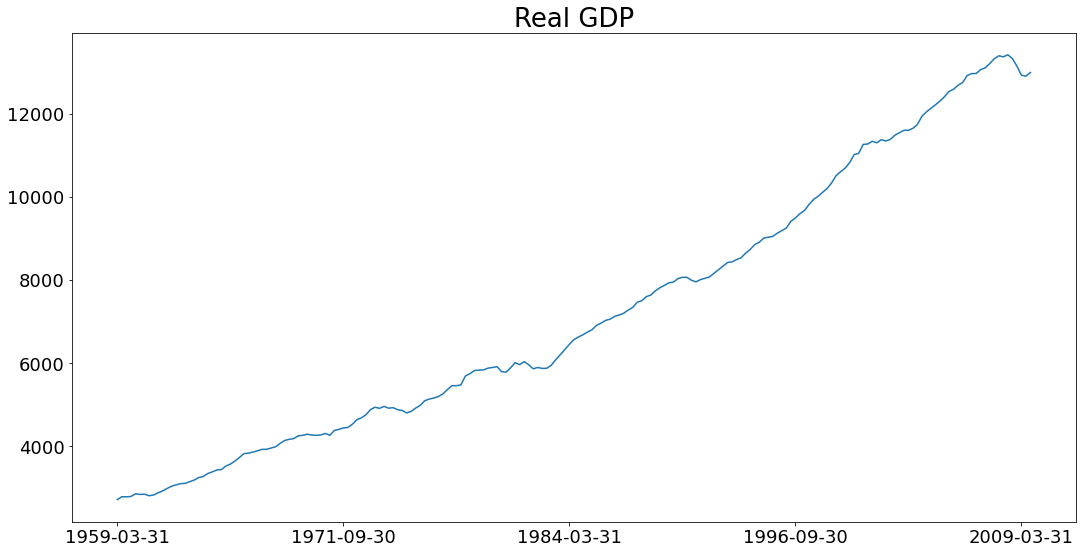

In [9]:
# Plot our real GDP data.
plot_series(df,
           ['realgdp'],
           title = 'Real GDP',
           steps = 50)

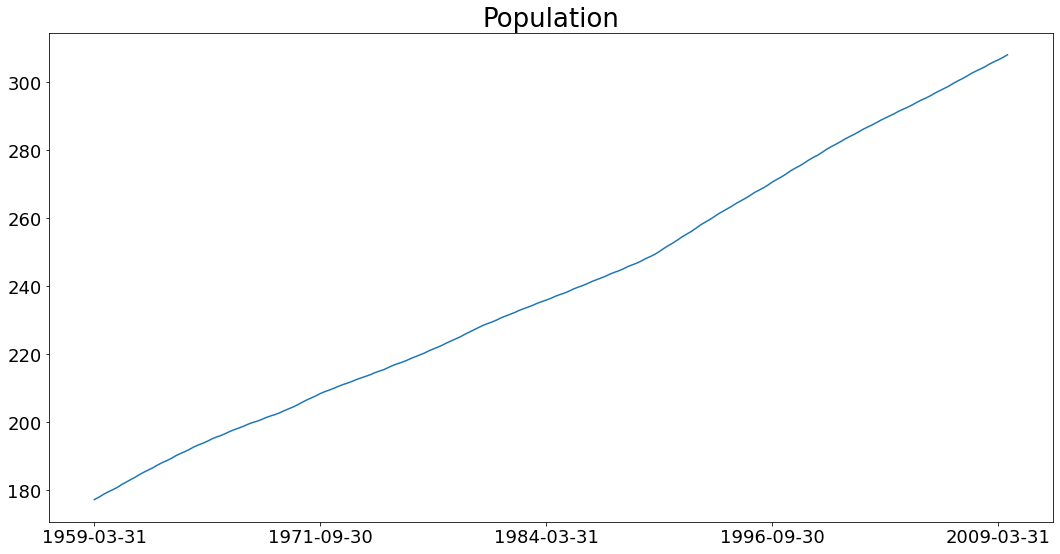

In [10]:
# Plot our population data.
plot_series(df,
           ['pop'],
           title = 'Population',
           steps = 50)

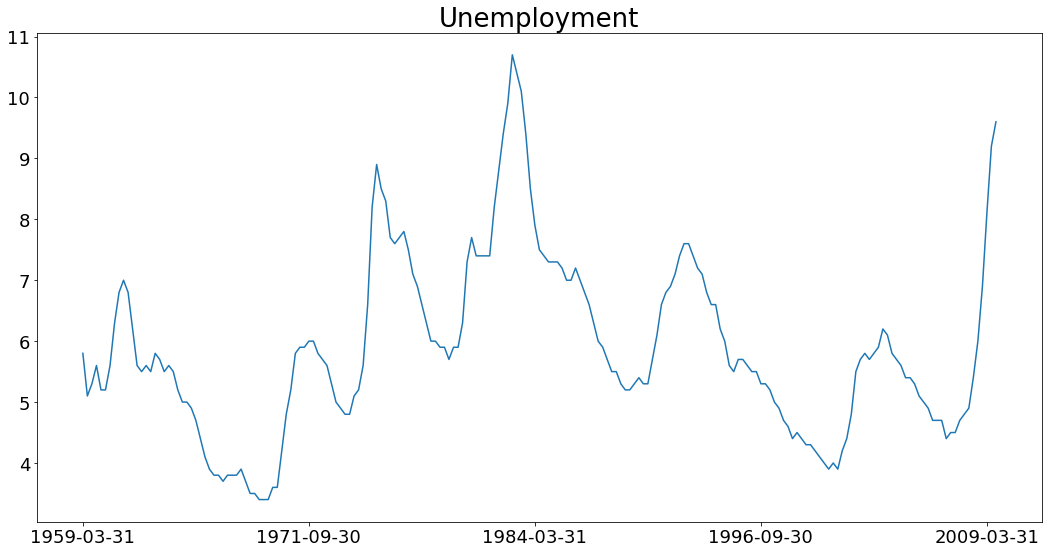

In [11]:
# Plot our unemployment data.
plot_series(df,
           ['unemp'],
           title = 'Unemployment',
           steps = 50)

### Model Fitting Process
1. Confirm stationarity of the data.
2. Train/test split.
3. Determine correct lag order $p$.
4. Fit model.
5. Generate forecasts.
6. Evaluate model and forecasts (if possible).

#### 1. Confirm stationarity of the data.
Vector autoregressive models require stationarity in order for us to fit them!

<details><summary>How would you describe stationarity?</summary>

- When our time series does not have systematic changes over time.
- Constant mean, correlation that only depends on lag (and not point in time).
</details>

<details><summary>What do we use to check whether or not a time series is stationary?</summary>

- Augmented Dickey-Fuller test!
</details>

In [12]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [13]:
# Run ADF test on the original Real GDP data.
interpret_dftest(adfuller(df['realgdp']))

Test Statistic    1.750463
p-value           0.998246
dtype: float64

<details><summary>Based on the results here, what action should we take?</summary>

- Difference our data.
</details>

In [14]:
# Run ADF test on the first-differenced Real GDP data.
interpret_dftest(adfuller(df['realgdp'].diff(1).dropna()))

Test Statistic   -6.305696e+00
p-value           3.327882e-08
dtype: float64

In [15]:
# Create column.
df['first_diff_realgdp'] = df['realgdp'].diff(1)

In [16]:
df.head()

,realgdp,pop,unemp,first_diff_realgdp
1959-03-31,2710.349,177.146,5.8,NaN
1959-06-30,2778.801,177.830,5.1,68.452
1959-09-30,2775.488,178.657,5.3,-3.313
1959-12-31,2785.204,179.386,5.6,9.716
1960-03-31,2847.699,180.007,5.2,62.495


Assuming $\alpha=0.01$, take two minutes to achieve stationarity for `pop` and `unemp`. If needed, create the columns we want to model.

In [17]:
# Run the ADF test for pop.
interpret_dftest(adfuller(df['pop']))

Test Statistic    1.730647
p-value           0.998201
dtype: float64

In [18]:
# Run the ADF test for first-differenced pop.
interpret_dftest(adfuller(df['pop'].diff(1).dropna()))

Test Statistic   -1.615825
p-value           0.474919
dtype: float64

In [19]:
# Run the ADF test for second-differenced pop.
interpret_dftest(adfuller(df['pop'].diff(1).diff(1).dropna()))

Test Statistic   -4.397672
p-value           0.000300
dtype: float64

In [20]:
# create second differenced pop column

df['second_diff_pop'] = df['pop'].diff(1).diff(1)

In [21]:
# Run ADF test for original unemp
interpret_dftest(adfuller(df['unemp']))

Test Statistic   -2.536458
p-value           0.106854
dtype: float64

In [22]:
# Run ADF test for first_differenced unemp
interpret_dftest(adfuller(df['unemp'].diff(1).dropna()))

Test Statistic   -4.168475
p-value           0.000745
dtype: float64

In [23]:
# Create first difference unemp column

df['first_diff_unemp'] = df['unemp'].diff(1)

#### 2. Train/test split.

In [24]:
# Subset our data.
df = df[['first_diff_realgdp', 'second_diff_pop', 'first_diff_unemp']]

# Let's get rid of rows containing missing values.
df.dropna(inplace = True)

/Users/henrybutler/opt/anaconda3/envs/dsir-111/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [25]:
df.head()

,first_diff_realgdp,second_diff_pop,first_diff_unemp
1959-09-30,-3.313,0.143,0.2
1959-12-31,9.716,-0.098,0.3
1960-03-31,62.495,-0.108,-0.4
1960-06-30,-13.309,0.043,0.0
1960-09-30,4.632,0.193,0.4


In [26]:
# What am I missing?

train, test = train_test_split(df,
                               test_size = 0.25,
                              shuffle = False)

#### 3. Determine correct lag order $p$.

We can check out autocorrelation plots and partial autocorrelation plots to attempt to figure out how many previous values of **each variable** we want in our model.

Suppose I select $p=2$.

$$
\begin{eqnarray*}
Y^{(d)}_{1,t} &=& \beta_0 + \beta_1Y^{(d)}_{1,t-1} + \beta_2Y^{(d)}_{1,t-2} + \beta_3Y^{(d)}_{2,t-1} + \beta_4Y^{(d)}_{2,t-2} + \beta_5Y^{(d)}_{3,t-1} + \beta_6Y^{(d)}_{3,t-2} \\
\\
Y^{(d)}_{2,t} &=& \gamma_0 + \gamma_1Y^{(d)}_{1,t-1} + \gamma_2Y^{(d)}_{1,t-2} + \gamma_3Y^{(d)}_{2,t-1} + \gamma_4Y^{(d)}_{2,t-2} + \gamma_5Y^{(d)}_{3,t-1} + \gamma_6Y^{(d)}_{3,t-2} \\
\\
Y^{(d)}_{3,t} &=& \delta_0 + \delta_1Y^{(d)}_{1,t-1} + \delta_2Y^{(d)}_{1,t-2} + \delta_3Y^{(d)}_{2,t-1} + \delta_4Y^{(d)}_{2,t-2} + \delta_5Y^{(d)}_{3,t-1} + \delta_6Y^{(d)}_{3,t-2}
\\
\end{eqnarray*}
$$

However, we can automate the selection of $p$ using a metric called the Akaike information criterion, or the AIC.

##### AIC

The AIC is a metric that is commonly used for time series models or in more "statistics-oriented" fields.
- Recall that models are just simplifications of reality. AIC attempts to measure how much information we lose when we simplify reality with a model.
- The lower the AIC, the better!
- More details can be found at the [Wikipedia page](https://en.wikipedia.org/wiki/Akaike_information_criterion).

We can actually find a good value of $p$ when we fit our model!

#### 4. Fit model.

In [27]:
# Instantiate a VAR model. Remember that we pass
# our data in during instantiation in statsmodels!
model = VAR(train)

/Users/henrybutler/opt/anaconda3/envs/dsir-111/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  warnings.warn('No frequency information was'


In [28]:
# Fit our model and use AIC to select the value of p.

ts_model = model.fit(maxlags = 15, # what is the largest possible value of p?
                     ic = 'aic')   # what "information criterion" (ic) will we use to decide what's "best?"

In [29]:
# What is the order of our autoregressive model? 
ts_model.k_ar

4

In [30]:
# Check out the summary of our model!
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Jan, 2022
Time:                     12:46:28
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                  -0.996910
Nobs:                     146.000    HQIC:                  -1.47007
Log likelihood:          -451.540    FPE:                   0.166546
AIC:                     -1.79390    Det(Omega_mle):        0.128944
--------------------------------------------------------------------
Results for equation first_diff_realgdp
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        23.250741        10.473768            2.220           0.026
L1.first_diff_realgdp         0.103736         0.100731            1.030           0.303
L1.second_diff_

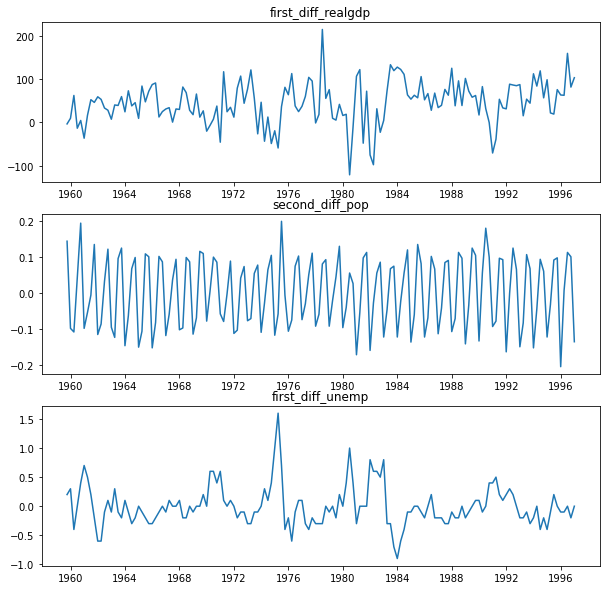

In [31]:
# Plot our training data.
ts_model.plot();

#### 5. Generate forecasts.

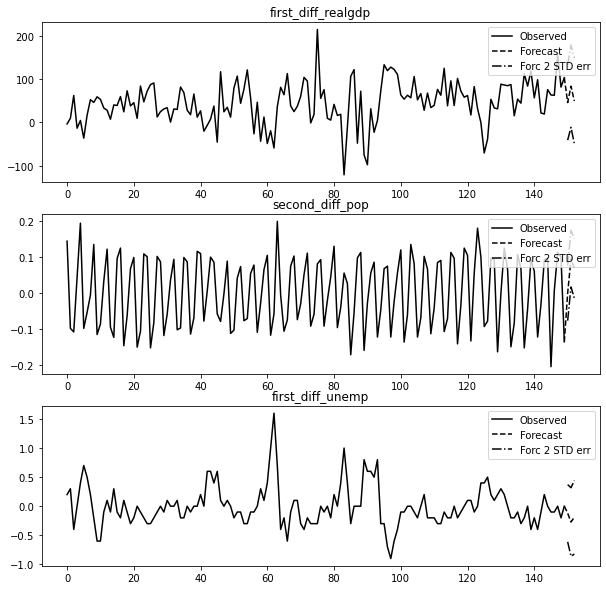

In [32]:
# Plot the forecast looking 3 steps ahead.
ts_model.plot_forecast(3);

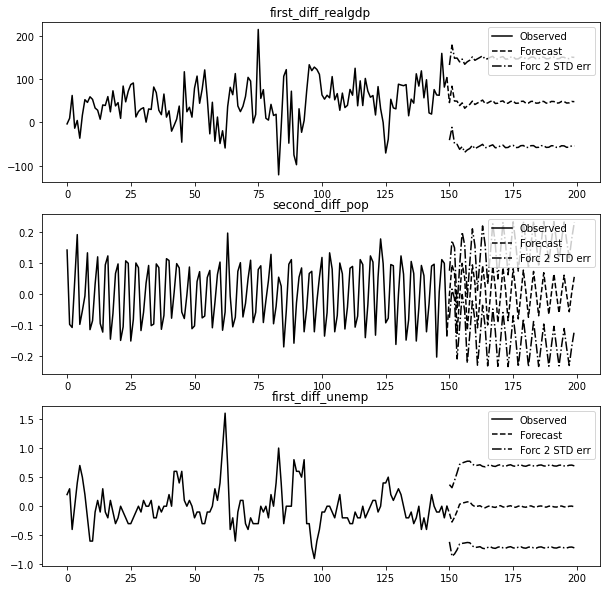

In [33]:
# Plot the forecast looking 50 steps ahead.
ts_model.plot_forecast(50);

In [34]:
# Generate a forecast one step ahead.
ts_model.forecast(train.values, 1)

array([[ 4.60133719e+01, -4.35975472e-04, -1.21245774e-01]])

In [35]:
# Generate a forecast five steps ahead.
ts_model.forecast(train.values, 5)

array([[ 4.60133719e+01, -4.35975472e-04, -1.21245774e-01],
       [ 8.39109946e+01,  9.49079885e-02, -2.71839880e-01],
       [ 4.96001022e+01,  6.76670319e-02, -1.90197121e-01],
       [ 4.92837943e+01, -1.27157164e-01, -8.64169194e-02],
       [ 3.90626298e+01, -7.29535302e-03,  3.46047233e-02]])

In [36]:
# Generate a forecast that matches our testing set.
ts_model.forecast(train.values, len(test))

array([[ 4.60133719e+01, -4.35975472e-04, -1.21245774e-01],
       [ 8.39109946e+01,  9.49079885e-02, -2.71839880e-01],
       [ 4.96001022e+01,  6.76670319e-02, -1.90197121e-01],
       [ 4.92837943e+01, -1.27157164e-01, -8.64169194e-02],
       [ 3.90626298e+01, -7.29535302e-03,  3.46047233e-02],
       [ 4.53110064e+01,  9.99029602e-02,  5.21223486e-02],
       [ 3.28672292e+01,  5.15480699e-02,  6.32787030e-02],
       [ 3.84698459e+01, -1.16634756e-01,  7.49054219e-02],
       [ 4.19244233e+01, -1.34473806e-02,  7.28128870e-02],
       [ 4.94275630e+01,  9.48906389e-02,  2.08012675e-02],
       [ 4.15626509e+01,  3.62083154e-02, -6.71500060e-03],
       [ 4.49504704e+01, -1.09126582e-01, -8.88058034e-05],
       [ 4.82000442e+01, -1.44566394e-02,  8.25916689e-03],
       [ 5.17925411e+01,  9.24596738e-02, -1.92757334e-02],
       [ 4.38708771e+01,  2.79263106e-02, -2.68906544e-02],
       [ 4.51195394e+01, -9.99923189e-02, -5.62392018e-03],
       [ 4.84578553e+01, -1.21217648e-02

In [37]:
# See the values of our test set.
test.values

array([[ 7.37770e+01, -5.60000e-02, -1.00000e-01],
       [ 1.43316e+02,  1.06000e-01, -2.00000e-01],
       [ 1.23121e+02,  1.11000e-01, -1.00000e-01],
       [ 7.62020e+01, -1.66000e-01, -2.00000e-01],
       [ 9.45510e+01, -9.60000e-02, -1.00000e-01],
       [ 9.08520e+01,  1.33000e-01, -2.00000e-01],
       [ 1.34510e+02,  7.70000e-02,  1.00000e-01],
       [ 1.78788e+02, -1.01000e-01, -1.00000e-01],
       [ 9.36040e+01, -1.26000e-01, -1.00000e-01],
       [ 8.28700e+01,  1.83000e-01,  0.00000e+00],
       [ 1.35865e+02,  6.40000e-02, -1.00000e-01],
       [ 1.94340e+02, -1.35000e-01, -1.00000e-01],
       [ 2.87900e+01, -9.60000e-02, -1.00000e-01],
       [ 2.15410e+02,  5.50000e-02, -1.00000e-01],
       [ 9.41300e+00,  7.30000e-02,  1.00000e-01],
       [ 6.66770e+01, -9.50000e-02, -1.00000e-01],
       [-3.73730e+01, -6.00000e-02,  3.00000e-01],
       [ 7.40800e+01,  6.70000e-02,  2.00000e-01],
       [-3.11760e+01,  6.30000e-02,  4.00000e-01],
       [ 4.00530e+01, -9.90000e

#### 6. Evaluate model (and forecasts, if possible).

In [38]:
# Let's use MSE to evaluate our models.

# Save our forecast as forecast.
forecast = ts_model.forecast(train.values, len(test))

# Instantiate MSE values at 0.
mse_gdp = 0
mse_pop = 0
mse_unemp = 0

# Loop through each forecasted time point.
for time in range(len(test)):
    
    # Calculate (expected - observed) ** 2 and add to MSE.
    mse_gdp += (forecast[time][0] - test.values[time][0]) ** 2
    mse_pop += (forecast[time][1] - test.values[time][1]) ** 2
    mse_unemp += (forecast[time][2] - test.values[time][2]) ** 2

# Divide SSE to get MSE.
mse_gdp /= len(test)
mse_pop /= len(test)
mse_unemp /= len(test)
    
# Generate output.    
print(f'The test MSE on the Real GDP data is: {round(mse_gdp, 4)}')
print(f'The test MSE on the population data is: {round(mse_pop, 4)}')
print(f'The test MSE on the unemployment data is: {round(mse_unemp, 4)}')

The test MSE on the Real GDP data is: 6943.76
The test MSE on the population data is: 0.0033
The test MSE on the unemployment data is: 0.1159
